# Hands-On Vanilla GNN

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Ohtar10/icesi-advanced-dl/blob/main/Unidad%202%20-%20Graph%20Neural%20Networks/vanilla-gnn.ipynb)

En este notebook continuaremos el ejercicio anterior y construiremos una red neuronal grafal en su forma más básica. Esto nos permitirá entener como estas operan internamente, sobretodo, nos ayudará a construir una intuición de como funciona el Message Passing Framework a nivel general. Para efectos comparativos, utilizaremos el mismo dataset de Cora y el modelo MLP que definimos antes.

#### Referencias
- [Introduction: Hands-On Graph Neural Networks](https://colab.research.google.com/drive/1h3-vJGRVloF5zStxL5I0rSy4ZUPNsjy8?usp=sharing)
- [Pytorch Geometric - Colab Notebooks and Video Tutorials](https://pytorch-geometric.readthedocs.io/en/latest/get_started/colabs.html)
- [Hands-On Graph Neural Networks Using Python](https://www.amazon.com/Hands-Graph-Neural-Networks-Python/dp/1804617520/ref=sr_1_1?crid=3A0QN1RYH7QQP&dib=eyJ2IjoiMSJ9.-qrnI2P8riRrQ4N6OPe1T9dfnkNhYgbD_-VhWVg_MfGU6D4U1TYZdUeJzAAZ1zhM7oyFoU7g3g3DppC-4DGSfmfmBfPUimLKlEKzBnujFTDHedtcSZuiN9EbIyNLxgkYbwfb0Nq4XhQQQZlS4JYFrBs0-rpkS8EmRz1o2OEJ0qrL9EXU9EJuj9cxCWt7J5HFE4nrJJYOPsX9aI78tp1LAEJqdUW14r9RbOYob9JQK0M.wej4dkKelg8wk6GVu5yxbMuiXefgjxhK-E-2n4_dFBs&dib_tag=se&keywords=hands+on+graph+neural+networks+using+python&qid=1713378267&sprefix=handson+gra%2Caps%2C197&sr=8-1)

In [39]:
import pkg_resources
import warnings

warnings.filterwarnings('ignore')

installed_packages = [package.key for package in pkg_resources.working_set]
IN_COLAB = 'google-colab' in installed_packages

In [40]:
!test '{IN_COLAB}' = 'True' && wget  https://github.com/Ohtar10/icesi-advanced-dl/raw/main/Unidad%202%20-%20Graph%20Neural%20Networks/requirements.txt && pip install -r requirements.txt

In [41]:
if IN_COLAB:
    import torch

    !pip uninstall torch-scatter torch-sparse torch-geometric torch-cluster --y
    !pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
    !pip install git+https://github.com/pyg-team/pytorch_geometric.git

### Funciones utilitarias

Primero, definimos unas cuantas funciones utilitarias para visualizar los grafos. Simplemente añadimos una función más para dibujar más de un grafo a la vez.

In [42]:
import os
import torch
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
from typing import Optional, Any, Dict, Tuple
from torch_geometric.data import Dataset
from torch_geometric.data.data import BaseData


def visualize_graph(G, color: str):
    plt.figure(figsize=(15, 10))
    plt.axis('off')
    nx.draw_networkx(
        G,
        pos=nx.spring_layout(G, k=0.15, iterations=200, seed=1234),
        node_size=10,
        with_labels=False,
        node_color=color,
        cmap="Set2",
        width=0.15
    )
    plt.show()


def visualize_graphs(graphs: Dict[str, Dict[str, Any]]):
    fig, axs = plt.subplots(nrows=1, ncols=len(graphs), figsize=(30, 10))
    axs = axs.flatten()
    for idx, key in enumerate(graphs.keys()):
        G = graphs[key]['graph']
        classes = graphs[key]['classes']
        nx.draw_networkx(
            G,
            pos=nx.spring_layout(G, k=0.15, iterations=200, seed=1234),
            node_size=10,
            with_labels=False,
            node_color=classes,
            cmap="Set2",
            width=0.15,
            ax=axs[idx]
        )
        axs[idx].set_title(key)

    plt.show()


## Planetoid Cora Dataset

Este dataset es el equivalente al MNIST para graph learning. Consiste en una red de publicaciones cientificas y su respectivo tema que los caracteriza. En el subconjunto que vamos a usar en este notebook, hay siete categorías de publicaciones, organizadas de la siguiente manera:

- 0: Theory
- 1: Reinforcement Learning
- 2: Genetic Algorithms
- 3: Neural Networks
- 4: Probabilistic Methods
- 5: Case Based
- 6: Rule Learning

La librería Pytorch Geometric implementa unas funciones que nos facilitan la obtención y trabajo de este dataset. Y con ayuda de las funciones que hemos definido arriba, podrémos obtener información general sobre el conjunto de datos.

#### Referencias
- [The Cora Dataset](https://graphsandnetworks.com/the-cora-dataset/)

In [43]:
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx

dataset = Planetoid(root='.', name='Cora')
data = dataset[0]

Ahora, visualicemos el grafo.

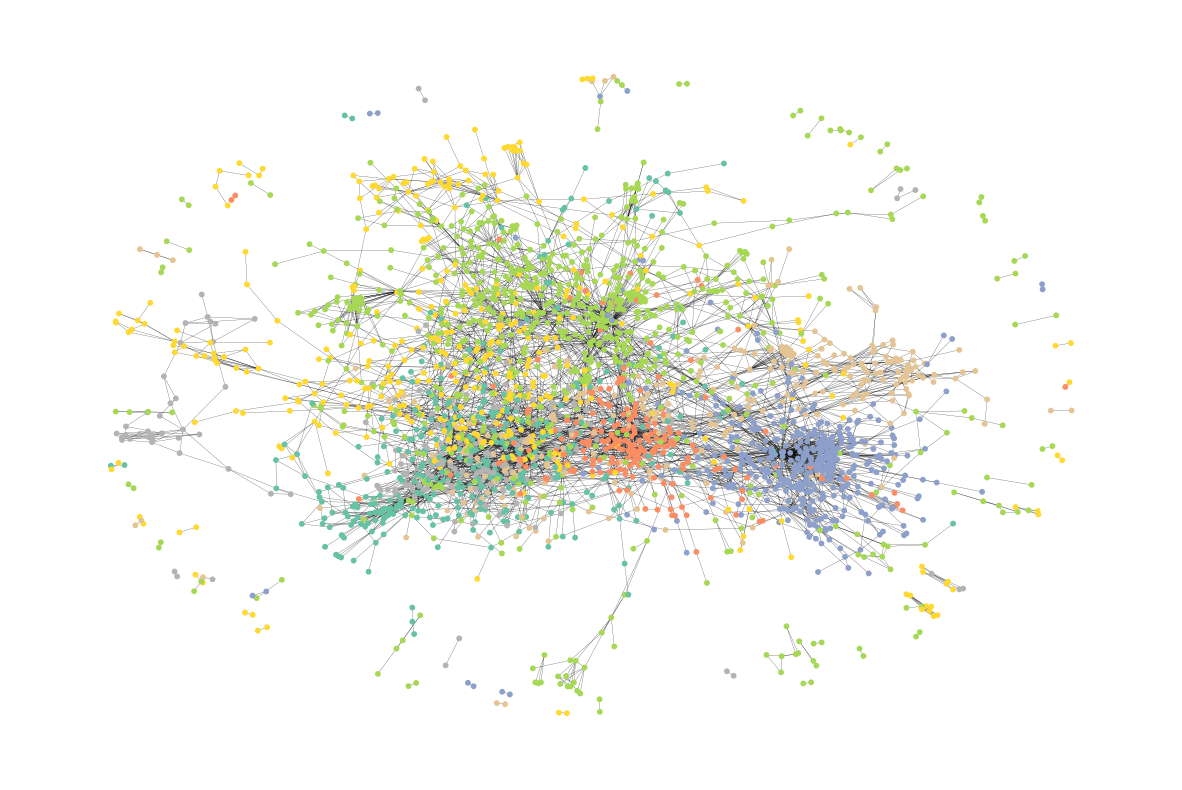

In [44]:
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

Este dataset empieza a ser lo suficientemente grande como para que con una visualización estática como la ofrecida por Networkx sea insuficiente para apreciarlo bien. Para visualizarlo completamente, es mejor exportar el grafo y visualizarlo en una herramienta externa como [yEd Live](https://www.yworks.com/yed-live/) o [Gephi](https://gephi.org). Aquí exportamos el grafo en formato `graphml` el cual podemos usar para importarlo en las herramientas mencionadas.

También se puede intentar visualizar con librerías interactivas como [pyvis](https://pyvis.readthedocs.io/en/latest/). Pero esto está por fuera el alcance de este notebook.

## Definición de la Red MLP para Grafos

Al igual que en el notebook anterior, definiremos primero una red MLP para efectos comparativos contra la red GNN que implementaremos más adelante. Recordemos que esta red lo único que hace es entrenar un clasificador en función del feature vector de cada nodo, sin tener en cuenta las relaciones de estos.

In [45]:
import torch
import torch.nn as nn
from torch.nn import functional as F
from pytorch_lightning import LightningModule, Trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks.early_stopping import EarlyStopping
from torch_geometric.data.lightning import LightningNodeData
from torchmetrics import Accuracy


class GraphMLP(LightningModule):

    def __init__(self, input_size: int, output_size: int):
        super(GraphMLP, self).__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size, 16),
            nn.ReLU(),
            nn.Linear(16, output_size),
            nn.LogSoftmax(dim=1)
        )
        self.train_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.val_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.test_acc = Accuracy(task='multiclass', num_classes=output_size)

        self.hparams['network'] = str(self.network)
        self.save_hyperparameters()

    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.network(x)
    

    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        y_hat = self(x)
        loss = F.cross_entropy(y_hat[batch.train_mask], y[batch.train_mask])
        self.train_acc(y_hat[batch.train_mask], y[batch.train_mask])
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        y_hat = self(x)
        self.val_acc(y_hat[batch.val_mask], y[batch.val_mask])
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        y_hat = self(x)
        self.test_acc(y_hat[batch.test_mask], y[batch.test_mask])
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
    

mlp_model = GraphMLP(dataset.num_features, dataset.num_classes)
tb_logger = TensorBoardLogger('tb_logs', name='GraphMLP')
callbacks=[EarlyStopping(monitor='train-loss', patience=3, mode='min')]
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger, callbacks=callbacks)

datamodule = LightningNodeData(
    data,
    input_train_nodes=data.train_mask,
    input_val_nodes=data.val_mask,
    input_test_nodes=data.test_mask,
    loader='neighbor',
    num_neighbors=[25, 10],
    batch_size=1024,
    num_workers=8
)
trainer.fit(mlp_model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | network   | Sequential         | 23.1 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 64: 100%|██████████| 1/1 [00:00<00:00, 17.31it/s, v_num=6, val-acc=0.552, train-loss=0.00656, train-acc=1.000]


Al terminar el entrenamiento, vemos que la red ha alcanzado una correctitud del $100\%$ en el conjunto de entrenamiento, pero solo un $51\%$ en el conjunto de validación. La red es muy buena mara memorizar los nodos de entrenamiento pero sufre de overfitting.

Ahora evaluemos el modelo en el conjunto de prueba.

In [46]:
mlp_model.eval()
result = trainer.test(mlp_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 132.45it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.5580000281333923
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


## Definición de modelo GNN simple (Vanilla)

Ahora procedemos con un modelo GNN simple. Este constará de dos capas GNN sencillas que definiremos. En la lección teórica, hablamos del *Message Passing Framework* como el mecanismo principal de las GNN, si bien esta red no representa completamente todo lo que puede ocurrir en el MPF, sirve para entender un poco que es lo que sucede y qué es lo que esta capa (`VanillaGNNLayer`) aporta.

Recordemos que el Message Passing Framework consta de:

1. Definición de un embedding $h_v^{k=0}$, donde $v$ representa a cada nodo y $k=0$ es la primera representación del nodo $v$.
2. Sea $a_v = f_{aggregate(h_v|y \in N(v))}$ una función de agregación que opera sobre el vecindario de $v$, es decir $N(v)$. Esta función puede ser una suma, multiplicación u otra operación que preferiblemente respete ciertas invarianzas, como el orden, escala, etc. Esta función podría estar parametrizada con una matriz $W$, lo cual la haría una red en si misma. Pero para este caso simple particular lo que pretendemos hacer es simplemente agregar las conexiones, por lo que nuestra capa sencilla sería:
$$
a_v = \sum_{u \in N(v)} h_u^k
$$
3. Se realiza un $f_{update}(a_v, h_v^k)$ sobre el nodo $v$ con los valores obtenidos de la activación. En este caso simple, el update es sencillamente un reemplazo, por lo que en la capa sería:
$$
h_v^{k+1} = a_v
$$

Ahora, dicha activación se puede lograr con una simple multiplicación de matrices (producto punto). Cuales? La matriz $H$ que representa los embeddings de cada nodo y la matriz de adyacencia $\tilde{A}=A+I$, donde $A$ es la matriz de adyacencia normal e $I$ es la matriz identidad, la cual agregaría auto conexiones a los nodos.

Entonces, para los embeddings tenemos:
$$
h_v = \sum{i \in N(v) x_iW^T}
$$
Donde, x es el vector embedding del nodo $i$ en el vecindario de $v$ y $W$ son los parámetros de entrenamiento del embedding. En otras palabras, esta es una capa lineal.

Por lo tanto, nuestra capa sencilla de GNN puede ser definida como:
$$
H = (\tilde{A})XW^T
$$
Donde, $(\tilde{A})$ es nuevamente la matriz de adyacencia, $X$ es la matriz de los embeddings de entrada y $W$ son los parámetros lineales.

Esto por qué funciona?, recordemos que el producto punto entre dos matrices $A_{n \times n}$ y $X_{n \times m}$, donde $m$ es la dimensionalidad del embedding y $n$ es el numero de nodos, resulta en una matriz $H_{n \times m}$, cada columna de la la matriz $X$ se multiplica y suma por cada fila de la matriz $A$, entonces aquí ocurre la función de agregación del MPF. Como la matriz $A$ solo contiene unos y ceros, al multiplicar, solo obtendremos valores cuando dos nodos están conectados y al sumar, obtendremos un vector agregado de ambas activaciones, efectivamente contemplando la información no solo de cada nodo individual, sino la de sus vecinos.

In [16]:
from torch_geometric.utils import to_dense_adj


class VanillaGNNLayer(nn.Module):
    def __init__(self, dim_in, dim_out):
        super(VanillaGNNLayer, self).__init__()
        self.linear = nn.Linear(dim_in, dim_out)
    
    def forward(self, x: torch.Tensor, adjacency: torch.Tensor) -> torch.Tensor:
        # Parte lineal de la capa, esto es XW^T
        x = self.linear(x)
        # Parte de la matriz de adyacencia, esto es A(XW^T)
        x = torch.sparse.mm(adjacency, x)
        return x
    

class VanillaGNN(LightningModule):

    def __init__(self, input_size: int, h_size: int, output_size: int):
        super(VanillaGNN, self).__init__()
        # Definimos las capas de la red.
        # Nótese que la capa GNN espera dos tensores de entrada, x y adjacency
        # Mientras que las capas ReLU y LogSoftmax solo esperan uno, x
        # Debemos tener en cuenta esto al momento de invocarlas.
        self.layers = nn.ModuleList(
            [
                VanillaGNNLayer(input_size, h_size),
                nn.ReLU(),
                VanillaGNNLayer(h_size, output_size),
                nn.LogSoftmax(dim=1)
            ]
        )

        self.train_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.val_acc = Accuracy(task='multiclass', num_classes=output_size)
        self.test_acc = Accuracy(task='multiclass', num_classes=output_size)

        self.hparams['layers'] = str(self.layers)
        self.save_hyperparameters()

    def forward(self, x: torch.Tensor, adjacency: torch.Tensor) -> torch.Tensor:
        # Ya no podemos invocar a las capas de forma secuencial
        # porque el numero de argumentos cambia entre ellas.
        # Entonces ahora las invocaremos por separado, pasando los argumentos
        # que cada capa espera.
        for i in range(len(self.layers)):
            if i % 2 == 0:
                x = self.layers[i](x, adjacency)
            else:
                x = self.layers[i](x)
        return x
    

    def get_adjacency_matrix(self, batch) -> torch.Tensor:
        # Dado que tenemos una lista de conexiones,
        # debemos obtener la matriz de adjacencia a partir de estos.
        adjacency = to_dense_adj(batch.edge_index)[0]
        adjacency += torch.eye(len(adjacency)).to(adjacency)
        return adjacency
    
    
    def training_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        # Debemos obtener la matriz ade adjacencia por cada training_step
        # debido a que entrenamos en baches, entonces la cantidad de nodos
        # y conexiones varia entre paso y paso.
        adjacency = self.get_adjacency_matrix(batch)
        y_hat = self(x, adjacency)
        loss = F.cross_entropy(y_hat[batch.train_mask], y[batch.train_mask])
        self.train_acc(y_hat[batch.train_mask], y[batch.train_mask])
        self.log('train-loss', loss, prog_bar=True, on_step=False, on_epoch=True)
        self.log('train-acc', self.train_acc, prog_bar=True, on_step=False, on_epoch=True)
        return loss


    def validation_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        adjacency = self.get_adjacency_matrix(batch)
        y_hat = self(x, adjacency)
        self.val_acc(y_hat[batch.val_mask], y[batch.val_mask])
        self.log('val-acc', self.val_acc, prog_bar=True, on_step=False, on_epoch=True)


    def test_step(self, batch, batch_idx) -> torch.Tensor:
        x, y = batch.x, batch.y
        adjacency = self.get_adjacency_matrix(batch)
        y_hat = self(x, adjacency)
        self.test_acc(y_hat[batch.test_mask], y[batch.test_mask])
        self.log('test-acc', self.test_acc, prog_bar=True, on_step=False, on_epoch=True)


    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.01, weight_decay=5e-4)
    

vanilla_gnn_model = VanillaGNN(dataset.num_features, 16, dataset.num_classes)
tb_logger = TensorBoardLogger('tb_logs', name='VanillaGNN')
callbacks=[EarlyStopping(monitor='train-loss', patience=3, mode='min')]
trainer = Trainer(max_epochs=100, devices=1, logger=tb_logger, callbacks=callbacks)

datamodule = LightningNodeData(
    data,
    input_train_nodes=data.train_mask,
    input_val_nodes=data.val_mask,
    input_test_nodes=data.test_mask,
    loader='neighbor',
    num_neighbors=[25, 10],
    batch_size=1024,
    num_workers=8
)
trainer.fit(vanilla_gnn_model, datamodule)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type               | Params
-------------------------------------------------
0 | layers    | ModuleList         | 23.1 K
1 | train_acc | MulticlassAccuracy | 0     
2 | val_acc   | MulticlassAccuracy | 0     
3 | test_acc  | MulticlassAccuracy | 0     
-------------------------------------------------
23.1 K    Trainable params
0         Non-trainable params
23.1 K    Total params
0.092     Total estimated model params size (MB)


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Epoch 21: 100%|██████████| 1/1 [00:00<00:00, 14.49it/s, v_num=10, val-acc=0.724, train-loss=0.0394, train-acc=1.000]


De entrada vemos que hay una mejoría en el conjunto de validación, hemos pasado del $\sim50\%$ al $\sim70\%$, una nada despreciable mejora del $\sim20\%$. Ahora veamos como se comporta en el conjunto de prueba.

In [48]:
vanilla_gnn_model.eval()
result = trainer.test(vanilla_gnn_model, datamodule.test_dataloader())

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing DataLoader 0: 100%|██████████| 1/1 [00:00<00:00, 46.92it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test-acc            0.7699999809265137
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


Como era de esperarse, la mejora también se ve reflejada en el conjunto de prueba donde la mejora del $\sim20\%$ se mantiene. Ahora observemos el proceso de entrenamiento.

In [1]:
%load_ext tensorboard

In [3]:
%tensorboard --logdir tb_logs/

Reusing TensorBoard on port 6006 (pid 125647), started 0:00:20 ago. (Use '!kill 125647' to kill it.)

De primera mano, podemos observar que el modelo VanillaGNN no solo logra una mejor correctitud en los conjuntos de validación y prueba, también converge más rápido, solo fueron necesarias aproximadamente la mitad de iteraciones que en el modelo MLP. Lo anterior incluso a pesar de que al final del entrenamiento del MLP, pareciera que obtuvimos menos pérdida que en el modelo GNN, pero esto solamente quiere decir que el modelo MLP está sesgado con el conjunto de prueba, lo cual hace más robusto el modelo GNN.

### Haciendo predicciones

Ahora hagamos uso de los modelos.

In [17]:
test_indices = data.test_mask.nonzero(as_tuple=False).squeeze()
test_nodes = data.x
test_edges = data.edge_index[:, test_indices.tolist()].T.tolist()
test_y = data.y[data.test_mask]

In [21]:
def build_output_graph(data, targets):
    graph = nx.Graph()
    for source, target in data.edge_index.T.tolist():
        if data.test_mask[source] and data.test_mask[target]:
            graph.add_edge(source, target)

    classes = []
    for node in graph.nodes:
        classes.append(targets[node])

    return graph, classes

In [37]:
# Ground Truth
test_graph, test_classes = build_output_graph(data, data.y)

# Predicciones MLP
mlp_pred = mlp_model(data.x[data.test_mask])
mlp_pred = torch.argmax(mlp_pred, dim=1)
node_preds = dict(zip(test_indices.tolist(), mlp_pred.tolist()))
mlp_graph, mlp_preds = build_output_graph(data, node_preds)

# Predicciones Vanilla GNN
adjacency = vanilla_gnn_model.get_adjacency_matrix(data)
vgnn_pred = vanilla_gnn_model(data.x, adjacency)
vgnn_pred = vgnn_pred[data.test_mask]
vgnn_pred = torch.argmax(vgnn_pred, dim=1)
node_preds = dict(zip(test_indices.tolist(), vgnn_pred.tolist()))
vgnn_graph, vgnn_preds = build_output_graph(data, node_preds)

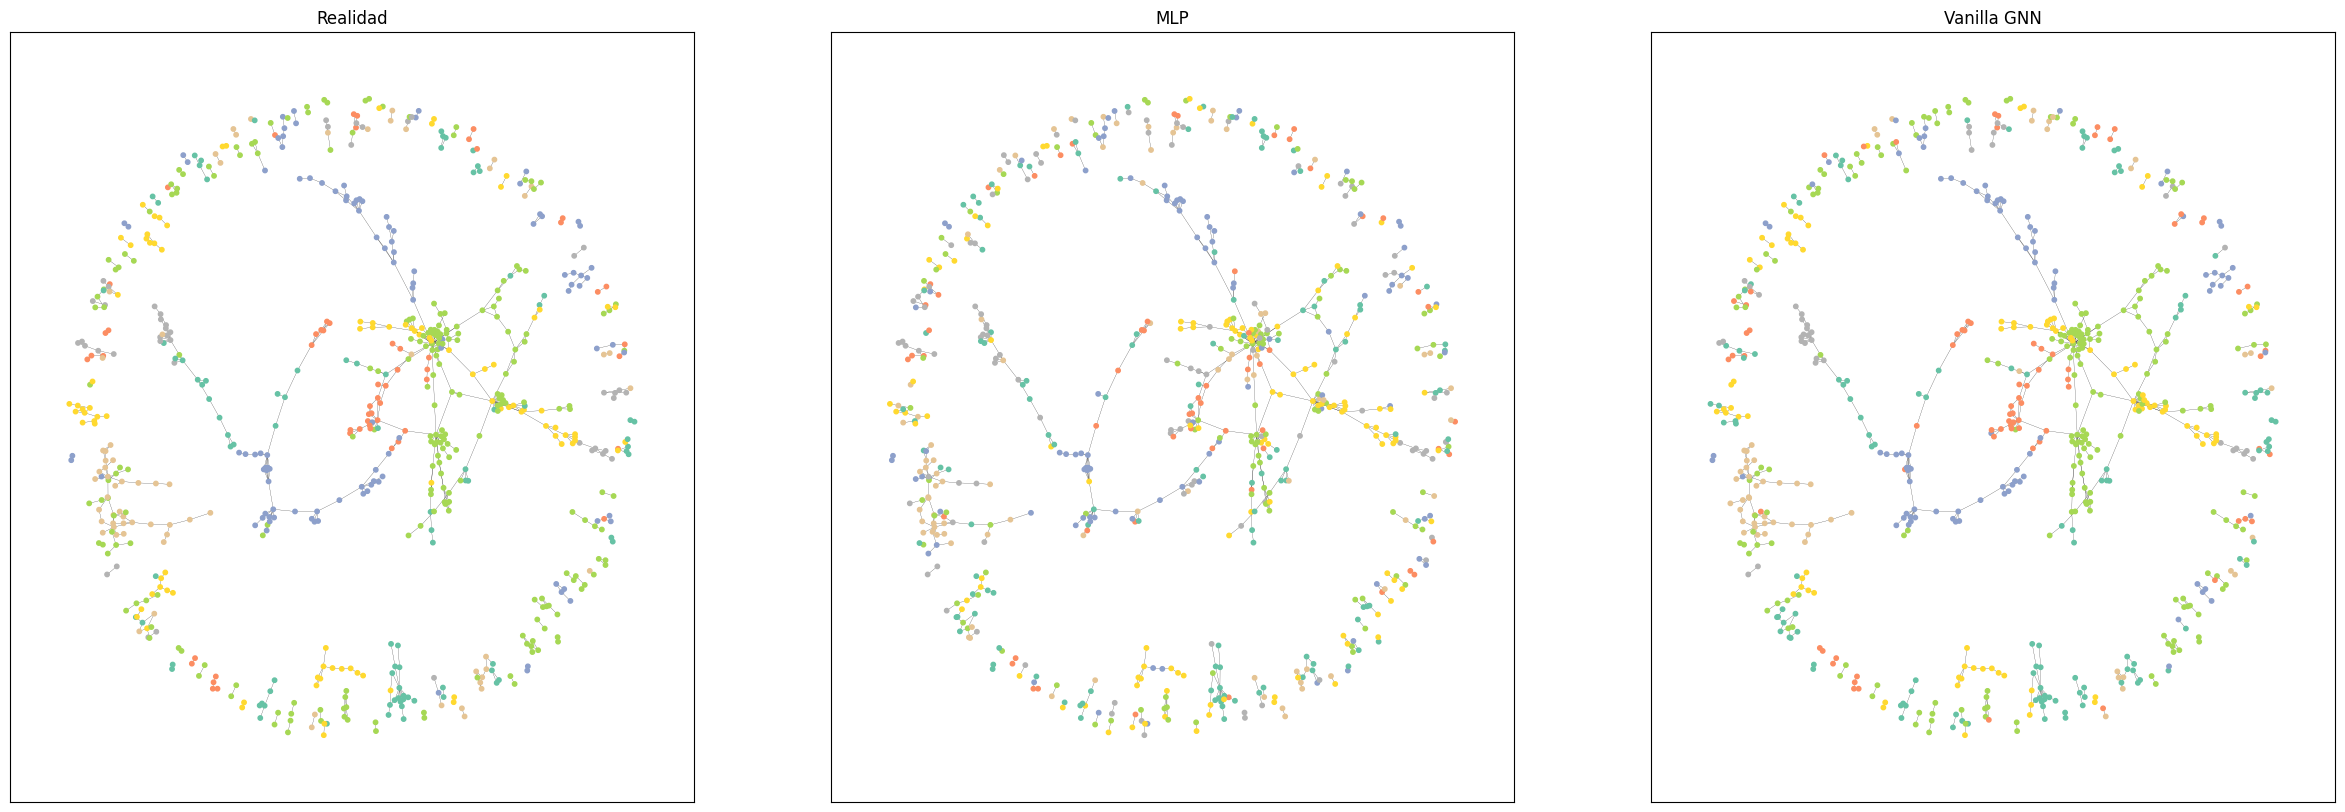

In [38]:
visualize_graphs(
    {
        'Realidad': dict(graph=test_graph, classes=test_classes), 
        'MLP': dict(graph=mlp_graph, classes=mlp_preds),
        'Vanilla GNN': dict(graph=vgnn_graph, classes=vgnn_preds),
        }
)

## Conclusiones

- Dados los resultados, podemos concluir que la inclusión de las conexiones en el modelo contribuyeron a una mejora significativa en la correctitud de las predicciones, lo cual sustenta el punto de valor de las capas GNN.
- Hemos podido lograr una mejora significativa incluso con una capa sencilla de GNN, no hemos incorporado parámetros de entrenamiento para la función de agregación ni update ni tampoco hemos definido más complejidades en estos.
- Visualmente observamos que en efecto, las predicciones son mejores que las del modelo MLP, particularmente aquellos nodos débilmente conectados, la contribución de sus vecinos facilitó la clasificación de los mismos.